In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [2]:
# Datapath AAPL
os.chdir('C:\\Users\\asus\\Documents\\Python Projects\\Trading - Research and Backtest\\AAPL')
datapath = os.getcwd() + '\\Databases\\'
files = []
for (dirpath, dirnames, filenames) in os.walk(datapath):
    files.extend(filenames)
    break
print(files)
df_aapl = pd.read_csv(datapath+'AAPL-1d.csv', parse_dates=True, index_col='Date')
print(df_aapl.head())

['AAPL-15min.csv', 'AAPL-1d.csv', 'AAPL-1min.csv', 'AAPL-1mo.csv', 'AAPL-1wk.csv', 'AAPL-2min.csv', 'AAPL-30min.csv', 'AAPL-3mo.csv', 'AAPL-5d.csv', 'AAPL-5min.csv', 'AAPL-60min.csv', 'AAPL-90min.csv']
            Open  High   Low  Close  Adj Close     Volume  Dividends  \
Date                                                                   
1980-12-12  0.51  0.52  0.51   0.51       0.40  117258400        0.0   
1980-12-15  0.49  0.49  0.49   0.49       0.38   43971200        0.0   
1980-12-16  0.45  0.45  0.45   0.45       0.36   26432000        0.0   
1980-12-17  0.46  0.46  0.46   0.46       0.36   21610400        0.0   
1980-12-18  0.48  0.48  0.48   0.48       0.38   18362400        0.0   

            Stock Splits  
Date                      
1980-12-12           0.0  
1980-12-15           0.0  
1980-12-16           0.0  
1980-12-17           0.0  
1980-12-18           0.0  


In [3]:
# Datapath SPY
os.chdir('C:\\Users\\asus\\Documents\\Python Projects\\Trading - Research and Backtest\\SPY')
datapath = os.getcwd() + '\\Databases\\'
files = []
for (dirpath, dirnames, filenames) in os.walk(datapath):
    files.extend(filenames)
    break
print(files)
df_spy = pd.read_csv(datapath+'SPY-1d.csv', parse_dates=True, index_col='Date')
print(df_spy.head())

['SPY-15min.csv', 'SPY-1d.csv', 'SPY-1min.csv', 'SPY-1mo.csv', 'SPY-1wk.csv', 'SPY-2min.csv', 'SPY-30min.csv', 'SPY-3mo.csv', 'SPY-5d.csv', 'SPY-5min.csv', 'SPY-60min.csv', 'SPY-90min.csv']
             Open   High    Low  Close  Adj Close   Volume  Dividends  \
Date                                                                    
1993-01-29  43.97  43.97  43.75  43.94      26.18  1003200        0.0   
1993-02-01  43.97  44.25  43.97  44.25      26.37   480500        0.0   
1993-02-02  44.22  44.38  44.12  44.34      26.43   201300        0.0   
1993-02-03  44.41  44.84  44.38  44.81      26.71   529400        0.0   
1993-02-04  44.97  45.09  44.47  45.00      26.82   531500        0.0   

            Stock Splits  
Date                      
1993-01-29             0  
1993-02-01             0  
1993-02-02             0  
1993-02-03             0  
1993-02-04             0  


In [4]:
# Dataframe merge
df_merge = pd.DataFrame([df_aapl.loc['2018-01-01':'2019-06-30']['Close'], df_spy.loc['2018-01-01':'2019-06-30':]['Close']], 
                        index=['Close_AAPL', 'Close_SPY']).T

In [118]:
# Shift SPY Price by 1 day
"""Since we want to know the effect of SPY to AAPL, so we regress AAPL(t) on SPY(t-1)"""
df_merge['Close_SPY'] = df_merge['Close_SPY'].shift(1)

In [119]:
# Regress against change from yesterday's price instead of today
df_merge['Returns'] = df_merge['Close_AAPL']/df_merge['Close_AAPL'].shift(1) - 1
df_merge

,Close_AAPL,Close_SPY,Returns
Date,,,
2018-01-03,172.23,NaN,NaN
2018-01-04,173.03,268.77,0.004645
2018-01-05,175.00,270.47,0.011385
2018-01-08,174.35,271.61,-0.003714
2018-01-09,174.33,273.42,-0.000115
...,...,...,...
2019-06-24,198.58,295.86,-0.001006
2019-06-25,195.57,294.00,-0.015158
2019-06-26,199.80,293.64,0.021629


In [120]:
# Remove row with NaN Value
df_merge.dropna(inplace=True)
df_merge

,Close_AAPL,Close_SPY,Returns
Date,,,
2018-01-04,173.03,268.77,0.004645
2018-01-05,175.00,270.47,0.011385
2018-01-08,174.35,271.61,-0.003714
2018-01-09,174.33,273.42,-0.000115
2018-01-10,174.29,273.92,-0.000229
...,...,...,...
2019-06-24,198.58,295.86,-0.001006
2019-06-25,195.57,294.00,-0.015158
2019-06-26,199.80,293.64,0.021629


Now lets use all of the data to build our model, and then test our model with the same data and see what happens.

First lets import from sklearn a very easy to use regression model for demonstrative purposes, and the mean_squared_error function to help us generate a root mean squared evaluation function for testing our model:

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Note that in sklearn often you will find both a “Regressor” and “Classifier” version of the same algorithm (for instance in this case RandomForest). You simply want to use the classifier version when you are predicting into a finite number of categories (for instance horse, shoe, duck) and the regressor version when you are attempting to predict a continuous numerical output (as we are here).

Now lets create our training dataframe, and our target dataframe:

In [160]:
# Set the training data columns and target variable
y_train = df_merge['Returns']
X_train = df_merge.drop(columns=['Close_AAPL', 'Returns'])

And initialise a RandomForestRegressor with a few hyper-parameter values set. Note that:

random_state just governs the initialisation parameters for the algorithm- if we define it explicitly we will get completely repeatable results, otherwise it is chosen randomly and so the final model will vary slightly every time
max_depth is a variable controlling the depth of the decision trees spawned in the forest- the greater the depth the more splits the model can make on the data- as a function of 2^(max_depth) ), allowing the model to grow more complex
n_estimators is the number of individual decision trees in the “forest”

In [161]:
random_forest = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=1)

In [162]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [163]:
root_mean_squared_error = np.sqrt(mean_squared_error(y_train, random_forest.predict(X_train)))
root_mean_squared_error

0.01588624137320322

Okay, so we have an error of 0.015 as a baseline performance for our model.

In [164]:
_ = np.abs(y_train).mean()
_ = root_mean_squared_error / _ * 100
print(str(round(_, 2))+'%')

123.7%


Note that this is pretty horrible since the average return (which you can calculate with (np.abs(y_train)).mean() ) is 0.012 so our average error is ~123% the size of the average daily return so clearly our model is not very accurate.

This isn’t really surprising though since we are using nothing but a single numerical value (yesterday’s bond spread) and an un-calibrated (and perhaps inappropriate type of) model to estimate the daily return- if markets were really that easy to predict we would all be rich!

This doesn’t really matter though and for the purposes of this article we will ignore our objectively horrible results- the focus is on using the dataset to provide demonstrative code for the topics we are exploring, and not the actual skill of our models.

In any case we can still fiddle with the model hyper-parameters to try and improve our performance.

For instance we can increase the max-depth of our random forest (which if we remember allows the model to make more splits on the data and thus grow more complex):

In [165]:
random_forest = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=1)
random_forest.fit(X_train, y_train)
root_mean_squared_error = np.sqrt(mean_squared_error(y_train, random_forest.predict(X_train)))
root_mean_squared_error

0.012768191789032815

In [166]:
_ = np.abs(y_train).mean()
_ = root_mean_squared_error / _ * 100
print(str(round(_, 2))+'%')

99.42%


In [167]:
unseen_data = pd.DataFrame([df_aapl.loc['2019-07-01':]['Close'], df_spy.loc['2019-07-01':]['Close']], 
                        index=['Close_AAPL', 'Close_SPY']).T
unseen_data['Close_SPY'] = unseen_data['Close_SPY'].shift(1)
unseen_data['Returns'] = unseen_data['Close_AAPL']/unseen_data['Close_AAPL'].shift(1) - 1
unseen_data.dropna(inplace=True)
unseen_data

,Close_AAPL,Close_SPY,Returns
Date,,,
2019-07-02,202.73,295.66,0.005855
2019-07-03,204.41,296.43,0.008287
2019-07-05,204.23,298.80,-0.000881
2019-07-08,200.02,298.46,-0.020614
2019-07-09,201.24,296.82,0.006099
...,...,...,...
2020-08-03,435.75,326.52,0.025198
2020-08-04,438.66,328.79,0.006678
2020-08-05,440.25,330.06,0.003625


In [169]:
y_unseen = unseen_data['Returns']
X_unseen = unseen_data.drop(columns=['Close_AAPL', 'Returns'])

In [170]:
root_mean_squared_error = np.sqrt(mean_squared_error(y_unseen, random_forest.predict(X_unseen)))
# print('RMSE'+str(root_mean_squared_error))
_ = np.abs(y_unseen).mean()
_ = root_mean_squared_error / _ * 100
print('RMSE: '+str(round(_, 2))+'%')

RMSE: 167.41%


This is a clear demonstration of overfitting in action.

In [171]:
y = df_merge['Returns']
X = df_merge.drop(columns=['Close_AAPL', 'Returns'])

train_fraction = 0.8
split_point = int(train_fraction*len(X))
X_train = X[0:split_point]
X_valid = X[split_point:]
y_train = y[0:split_point]
y_valid = y[split_point:]

OR

In [172]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=101)

In [173]:
print("len(df_merge): {}, split_point: {}, len(X_train): {}, len(X_valid): {}, len(y_train): {}, len(y_valid): {}"\
      .format(len(df_merge), split_point, len(X_train), len(X_valid), len(y_train), len(y_valid))) 

len(df_merge): 373, split_point: 298, len(X_train): 298, len(X_valid): 75, len(y_train): 298, len(y_valid): 75


In [174]:
import matplotlib.pyplot as plt

train_errors = []
valid_errors = []
param_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30,40,50,75,100]

for max_depth in param_range:
    random_forest = RandomForestRegressor(max_depth=max_depth, n_estimators=100, random_state=1)
    random_forest.fit(X_train, y_train)
    
    train_errors.append(np.sqrt(mean_squared_error(y_train, random_forest.predict(X_train))))
    valid_errors.append(np.sqrt(mean_squared_error(y_valid, random_forest.predict(X_valid))))

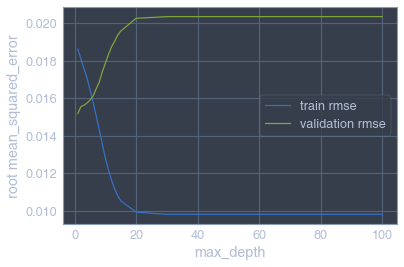

In [175]:
plt.xlabel('max_depth')
plt.ylabel('root mean_squared_error')
plt.plot(param_range, train_errors, label="train rmse")
plt.plot(param_range, valid_errors, label="validation rmse")
plt.legend()
plt.show()

In [176]:
valid_errors.index(min(valid_errors))

0

In [177]:
random_forest = RandomForestRegressor(max_depth=1, n_estimators=100, random_state=1)
random_forest.fit(X, y)
root_mean_squared_error = np.sqrt(mean_squared_error(y, random_forest.predict(X)))
root_mean_squared_error
_ = np.abs(y).mean()
_ = root_mean_squared_error / _ * 100
print('RMSE: '+str(round(_, 2))+'%')

RMSE: 140.22%


In [178]:
root_mean_squared_error = np.sqrt(mean_squared_error(y_unseen, random_forest.predict(X_unseen)))
root_mean_squared_error
_ = np.abs(y_unseen).mean()
_ = root_mean_squared_error / _ * 100
print('RMSE: '+str(round(_, 2))+'%')

RMSE: 154.19%


In [179]:
# split the full data 80:20 into training:validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=101)

# split training data 87.5:12.5 into training:testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.875, random_state=101)

print("len(X): {} len(y): {} \nlen(X_train): {}, len(X_valid): {}, len(X_test): \
{} \nlen(y_train): {}, len(y_valid): {}, len(y_test): {}".format(len(X), len(y),\
len(X_train), len(X_valid), len(X_test), len(y_train), len(y_valid), \
len(y_test))) 

len(X): 373 len(y): 373 
len(X_train): 260, len(X_valid): 75, len(X_test): 38 
len(y_train): 260, len(y_valid): 75, len(y_test): 38


In [231]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

In [180]:
tscv = TimeSeriesSplit(n_splits=5)

In [181]:
X_array = np.array(X)
y_array = np.array(y)

In [254]:
# Walk Forward Cross Validation
count = 0
depth = []
for train_index, test_index in tscv.split(X_array):
    # 80:20 training:validation inner loop split
    inner_split_point = int(0.8*len(train_index))
    valid_index = train_index[inner_split_point:]
    train_index = train_index[:inner_split_point]
    X_train, X_valid, X_test = X_array[train_index], X_array[valid_index], X_array[test_index]
    y_train, y_valid, y_test = y_array[train_index], y_array[valid_index], y_array[test_index]
    train_errors = []
    valid_errors = []
    for max_depth in param_range:
        random_forest = RandomForestRegressor(max_depth=max_depth, n_estimators=200, random_state=1)
        random_forest.fit(X_train, y_train)
        train_errors.append(np.sqrt(mean_squared_error(y_train, random_forest.predict(X_train))))
        valid_errors.append(np.sqrt(mean_squared_error(y_valid, random_forest.predict(X_valid))))
    max_depth = valid_errors.index(min(valid_errors)) + 1
    print('Max Depth optimal for validation data: '+str(max_depth))
    depth.append(max_depth)
    if count == 0:
        random_forest = RandomForestRegressor(max_depth=max_depth, n_estimators=100, random_state=1)
        count += 1
    else:
        pass
#     random_forest = RandomForestRegressor(max_depth=max_depth, n_estimators=200, random_state=1)
    X_train = np.append(X_train, X_valid)
    X_train = X_train.reshape(X_train.shape[0], 1)
    y_train = np.append(y_train, y_valid)
    y_train = y_train.reshape(y_train.shape[0])
    random_forest.fit(X_train, y_train)
    test_errors.append(np.sqrt(mean_squared_error(y_test, random_forest.predict(X_test))))
    root_mean_squared_error = np.sqrt(mean_squared_error(y_test, random_forest.predict(X_test)))
    _ = np.abs(y_test).mean()
    _ = root_mean_squared_error / _ * 100
    print('RMSE: '+str(round(_, 2))+'%')
    Rsquared = r2_score(y_test, random_forest.predict(X_test))
    print('R2: {}%'.format(round(Rsquared*100, 2)))

Max Depth optimal for validation data: 1
RMSE: 135.95%
R2: 5.27%
Max Depth optimal for validation data: 1
RMSE: 182.28%
R2: -84.91%
Max Depth optimal for validation data: 1
RMSE: 139.4%
R2: -30.11%
Max Depth optimal for validation data: 1
RMSE: 184.44%
R2: -36.45%
Max Depth optimal for validation data: 1
RMSE: 162.18%
R2: -37.75%


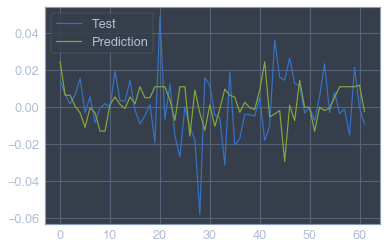

In [256]:
plt.plot(y_test, label='Test')
plt.plot(random_forest.predict(X_test), label='Prediction')
plt.legend()
plt.show()

In [287]:
#Walk forward cross validation
train_fraction = 0.8
split_point = int(train_fraction*len(X_array))
X_train = X_array[0:split_point]
X_test = X_array[split_point:]
y_train = y_array[0:split_point]
y_test = y_array[split_point:]
hist = X_train.copy()
pred_list = []
random_forest = RandomForestRegressor(max_depth=1, n_estimators=100, random_state=1)
for h in range(len(X_test)):
    random_forest.fit(X_train, y_train)
    y_predict = random_forest.predict(X_test[h].reshape(-1, 1))[0]
    pred_list = np.append(pred_list, y_predict)
    X_train = np.append(X_train[1:], X_test[h])
    X_train = X_train.reshape(X_train.shape[0], 1)
    y_train = np.append(y_train[1:], y_test[h])
    y_train = y_train.reshape(y_train.shape[0])

In [289]:
r2_score(y_test, pred_list)

-0.049240597478084513

In [288]:
pred_list

array([-5.45903150e-05, -3.32178106e-04, -3.48833221e-04, -6.60789181e-05,
       -4.01027305e-04, -5.65610315e-05, -4.12483865e-05, -2.40614142e-04,
       -3.91202014e-05, -7.52035617e-05, -2.51916073e-04,  1.11371372e-05,
       -3.16260095e-05, -4.88460758e-05, -9.01224764e-05, -2.18562524e-04,
        2.41198062e-04,  3.23961398e-04,  4.65153520e-04,  2.80833760e-04,
        4.44956000e-04,  4.63712558e-04,  4.90943666e-04,  7.20436498e-04,
        2.88695975e-04,  7.49885849e-04,  6.33681274e-04,  5.48465503e-04,
        7.46592839e-04,  5.49488158e-04,  6.65727250e-04,  7.45752107e-04,
        2.30411647e-04,  4.16736231e-04,  1.44220419e-02,  4.91449571e-04,
        6.42071737e-04,  7.21897021e-03,  1.62315891e-04,  5.76194037e-04,
        2.65601573e-04,  2.64985977e-04,  2.96132027e-05,  1.64710604e-04,
        2.45725855e-04, -9.94771238e-06,  2.89701799e-05, -9.62552040e-05,
       -1.46798859e-05,  5.96254603e-05, -1.84591096e-04,  1.21538914e-04,
       -8.46428683e-05,  